In [1]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
import pandas as pd

2022-04-06 17:46:58.012436: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-04-06 17:46:58.012465: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
df = pd.read_csv('/home/hrishikeshkanojiya/Desktop/outputs.csv')
df.head()

FileNotFoundError: [Errno 2] No such file or directory: '/home/hrishikeshkanojiya/Desktop/outputs.csv'

In [10]:
df['Category'].value_counts()

ham     4825
spam     747
Name: Category, dtype: int64

In [17]:
df_spam =df[df['Category']=='spam']
df_spam.shape

(747, 2)

In [18]:
df_ham =df[df['Category']=='ham']
df_ham.shape

(4825, 2)

In [22]:
df_ham_downsampled = df_ham.sample(df_spam.shape[0])

In [23]:
df_ham_downsampled.shape

(747, 2)

In [25]:
df_balanced = pd.concat([df_ham_downsampled,df_spam])
df_balanced.shape

(1494, 2)

In [26]:
df_balanced['Category'].value_counts()

ham     747
spam    747
Name: Category, dtype: int64

In [29]:
df_balanced['spam']= df_balanced['Category'].apply(lambda x:1 if x=='spam' else 0)
df_balanced.sample(10)

,Category,Message,spam
3639,spam,Customer service announcement. We recently tri...,1
1119,ham,I'm going 4 lunch now wif my family then aft d...,0
2369,ham,If you r @ home then come down within 5 min,0
1817,ham,Are you going to write ccna exam this week??,0
5015,ham,Hello boytoy ! Geeee ... I'm missing you today...,0
559,ham,Hi Princess! Thank you for the pics. You are v...,0
3334,spam,You are being contacted by our dating service ...,1
3792,spam,"Twinks, bears, scallies, skins and jocks are c...",1
4256,spam,Block Breaker now comes in deluxe format with ...,1
1282,ham,Am I the only one who doesn't stalk profiles?,0


In [33]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test= train_test_split(df_balanced['Message'],df_balanced['spam'],
                                               stratify=df_balanced['spam'])

In [34]:
X_train.head(5)

1765    Hi 07734396839 IBH Customer Loyalty Offer: The...
3009    Loan for any purpose £500 - £75,000. Homeowner...
1544    Hello from Orange. For 1 month's free access t...
5437                         Am slow in using biola's fne
4206    IMPORTANT INFORMATION 4 ORANGE USER 0796XXXXXX...
Name: Message, dtype: object

In [35]:
bert_preprocess = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3")
bert_encoder = hub.KerasLayer("https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/4")

2022-03-22 16:09:59.309129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-03-22 16:09:59.309155: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-03-22 16:09:59.309173: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (si-Latitude-5520): /proc/driver/nvidia/version does not exist
2022-03-22 16:09:59.309981: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-03-22 16:11:22.306175: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 93

In [40]:
def get_sentence_embeding(sentence):
    preprocess_text= bert_preprocess(sentence)
    return bert_encoder(preprocess_text)['pooled_output']

get_sentence_embeding(['how are doing'])

<tf.Tensor: shape=(1, 768), dtype=float32, numpy=
array([[-9.24413562e-01, -2.98449039e-01, -3.46621573e-01,
         8.33482683e-01, -2.24566013e-02, -8.26424211e-02,
         9.47942078e-01,  2.75199801e-01, -2.43003771e-01,
        -9.99972820e-01, -3.43356818e-01,  7.70513654e-01,
         9.88459170e-01,  1.06394127e-01,  9.67812836e-01,
        -7.72169888e-01, -3.92241478e-01, -6.11103237e-01,
         2.82318354e-01, -8.46158564e-01,  7.55791306e-01,
         9.97633338e-01,  4.41478789e-01,  2.97094107e-01,
         3.79107893e-01,  9.17428493e-01, -8.27228606e-01,
         9.64416504e-01,  9.68408525e-01,  7.70421207e-01,
        -8.09939384e-01,  7.35712945e-02, -9.90438998e-01,
        -1.70764923e-01, -3.77794802e-01, -9.94006634e-01,
         2.02536225e-01, -8.15082014e-01,  4.62330244e-02,
         4.95841466e-02, -9.29463625e-01,  2.71056652e-01,
         9.99819934e-01,  1.99688673e-01,  1.19910009e-01,
        -2.77724057e-01, -9.99999642e-01,  2.37128630e-01,
      

In [41]:
e = get_sentence_embeding([
    "banana", 
    "grapes",
    "mango",
    "jeff bezos",
    "elon musk",
    "bill gates"
]
)

In [46]:
from sklearn.metrics.pairwise import cosine_similarity
cosine_similarity([e[0]],[e[1]])

array([[0.99110866]], dtype=float32)

In [50]:
text_input = tf.keras.Input(shape=(),dtype=tf.string,name='text')
preprocessed_text= bert_preprocess(text_input)
outputs = bert_encoder(preprocessed_text)

#nlp layer
l = tf.keras.layers.Dropout(0.1,name="dropout")(outputs['pooled_output'])
l = tf.keras.layers.Dense(1,activation='sigmoid',name='output')(l)

#final model
model = tf.keras.Model(inputs=[text_input],outputs=[l])

In [51]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 text (InputLayer)              [(None,)]            0           []                               
                                                                                                  
 keras_layer (KerasLayer)       {'input_mask': (Non  0           ['text[0][0]']                   
                                e, 128),                                                          
                                 'input_type_ids':                                                
                                (None, 128),                                                      
                                 'input_word_ids':                                                
                                (None, 128)}                                                  

In [52]:
len(X_train)

1120

In [55]:
MATRICS = [
    tf.keras.metrics.BinaryAccuracy(name='Accuracy'),
    tf.keras.metrics.Precision(name='Precision'),
    tf.keras.metrics.Recall(name='recall')
]

model.compile(optimizer='adam',
             loss='binary_crossentropy',
             metrics=MATRICS)

In [56]:
model.fit(X_train, y_train, epochs=10)

Epoch 1/10


2022-03-22 16:54:09.735010: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.
2022-03-22 16:54:09.801418: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.
2022-03-22 16:54:10.116920: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.
2022-03-22 16:54:10.184661: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 50331648 exceeds 10% of free system memory.


35/35 [==============================] - 159s 4s/step - loss: 0.6255 - Accuracy: 0.6652 - Precision: 0.6742 - recall: 0.6393
Epoch 2/10
35/35 [==============================] - 153s 4s/step - loss: 0.5039 - Accuracy: 0.8089 - Precision: 0.7903 - recall: 0.8411
Epoch 3/10
35/35 [==============================] - 152s 4s/step - loss: 0.4412 - Accuracy: 0.8464 - Precision: 0.8440 - recall: 0.8500
Epoch 4/10
35/35 [==============================] - 152s 4s/step - loss: 0.3943 - Accuracy: 0.8634 - Precision: 0.8397 - recall: 0.8982
Epoch 5/10
35/35 [==============================] - 150s 4s/step - loss: 0.3593 - Accuracy: 0.8804 - Precision: 0.8647 - recall: 0.9018
Epoch 6/10
35/35 [==============================] - 150s 4s/step - loss: 0.3319 - Accuracy: 0.8848 - Precision: 0.8722 - recall: 0.9018
Epoch 7/10
35/35 [==============================] - 150s 4s/step - loss: 0.3234 - Accuracy: 0.8839 - Precision: 0.8707 - recall: 0.9018
Epoch 8/10
35/35 [==============================] - 151s 4s

In [57]:
model.evaluate(X_test, y_test)

12/12 [==============================] - 51s 4s/step - loss: 0.2760 - Accuracy: 0.9144 - Precision: 0.9058 - recall: 0.9251


[0.27600669860839844,
 0.9144384860992432,
 0.9057591557502747,
 0.9251337051391602]

In [63]:
y_predicted = model.predict(X_test)
y_predicted = y_predicted.flatten()

import numpy as np

y_predicted = np.where(y_predicted > 0.5, 1, 0)
y_predicted

array([0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0,
       0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 1,
       0, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0,
       1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0,
       1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1,
       1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1,
       0, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0,
       1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1,

In [65]:
from sklearn.metrics import confusion_matrix, classification_report

cm = confusion_matrix(y_test,y_predicted)
cm

array([[169,  18],
       [ 14, 173]])

Text(33.0, 0.5, 'Truth')

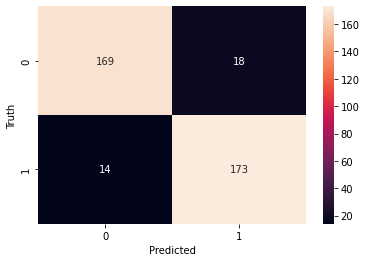

In [66]:
from matplotlib import pyplot as plt
import seaborn as sn
sn.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

In [67]:
print(classification_report(y_test, y_predicted))

              precision    recall  f1-score   support

           0       0.92      0.90      0.91       187
           1       0.91      0.93      0.92       187

    accuracy                           0.91       374
   macro avg       0.91      0.91      0.91       374
weighted avg       0.91      0.91      0.91       374



In [68]:
reviews = [
    'Enter a chance to win $5000, hurry up, offer valid until march 31, 2021',
    'You are awarded a SiPix Digital Camera! call 09061221061 from landline. Delivery within 28days. T Cs Box177. M221BP. 2yr warranty. 150ppm. 16 . p pÂ£3.99',
    'it to 80488. Your 500 free text messages are valid until 31 December 2005.',
    'Hey Sam, Are you coming for a cricket game tomorrow',
    "Why don't you wait 'til at least wednesday to see if you get your ."
]
model.predict(reviews)

array([[0.76356196],
       [0.8344021 ],
       [0.78699446],
       [0.19545141],
       [0.09324747]], dtype=float32)